In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
np.random.seed(12345)

In [2]:
def f0(Q, v, p):
    return ((v.T @ Q) @ v) + (p.T @ v)

def grad_f(A, b, v, t):
  df0 = 2 * np.dot(Q,v) + p
  dfi= np.zeros(n)
  for i in range(len(A)):
    dfi += A[i] / (- A[i] @ v0 + b[i])
  return t*df0 + dfi

def hess_f(A, b ,v, t):
  df0 = 2 * np.dot(Q,v) + p
  ddfi = np.zeros((n,n))
  for i in range(len(A)):
    ddfi += (1 / (A[i] @ v0 - b[i])**2) * np.outer(df0,df0)
  return 2*t*Q + ddfi

def f(Q, p, A, b, v, t):
	h = np.sum([ np.log(-A[i] @ v + b[i]) for i in range(len(A)) ])
	return t * (v @ Q @ v + v @ p) -  h

def centring_step(Q, p, A, b, t, v0 ,eps):
  v_seq = []
  while True :
    #1. Compute Newton step and decrement
    df = grad_f(A,b,v0, t)
    ddf = hess_f(A,b,v0, t )
    inv_ddf = np.linalg.inv(ddf)
    newton_step = -inv_ddf @ df
    lmbda = df @ inv_ddf @ df
    #2. Stopping criterion
    if lmbda/2 <= eps:
      break
    #3. Line search
    alpha = 0.5
    beta = 0.5
    step = 1
    while True:
      v_new = v0 + step * newton_step
      if f(Q,p,A,b,v_new,t) < f(Q,p,A,b,v0,t) + step* alpha * df @ newton_step:
        break
      step *= beta

    #4. Update
    v0 += step * newton_step
    v_seq.append(np.copy(v0))

    return v_seq


In [3]:
def barr_method(Q,p,A,b,v0,eps):
  v_seq = [v0]
  t = 1
  m = A.shape[0]
  while True:
    #1. Centering step
    x_seq = centring_step(Q,p,A,b,t,v_seq[-1],eps)
    #2. Update
    if x_seq != None :
      v_seq.append(x_seq[-1])
    #3. Stopping criterion
    if m/t < eps:
      break
    #4. Increase t
    t *= mu
  return v_seq

<ipython-input-2-c7a71eec971b>:19: RuntimeWarning: invalid value encountered in log
  h = np.sum([ np.log(-A[i] @ v + b[i]) for i in range(len(A)) ])


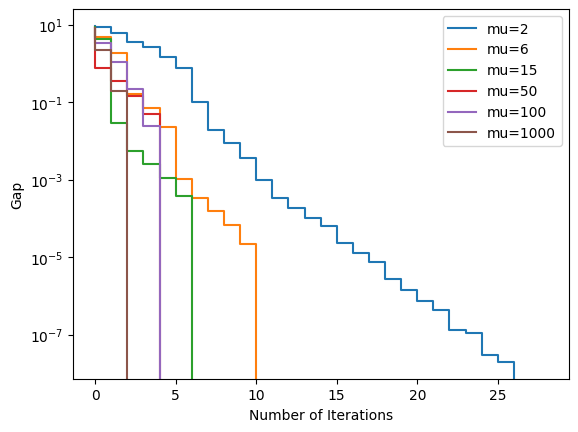

In [26]:
n = 100
d = 50
X = np.random.uniform(size = (n, d))
y = np.random.uniform(size = n)
Q = 0.5*np.eye(n)
A = np.vstack((X.T , -X.T))
p =  - y
b = 10 * np.ones((2*d,1))
eps=1e-6
mus = [2,6,15,50,100,1000]

fig = plt.figure()
f_star = []
for mu in mus:
  v0 = np.zeros(n)
  v_seq = barr_method(Q,p,A,b,v0,eps)
	# Gap
  gap = [f0(Q, v, p) - f0(Q, v_seq[-1], p) for v in v_seq]
  f_star.append(f0(Q, v_seq[-1], p))
  x = range(len(gap))
  plt.step(x, np.array(gap).flatten(), label=f"mu={mu}")

plt.semilogy()
plt.xlabel("Number of Iterations")
plt.ylabel("Gap")
plt.legend()
plt.show()

In [27]:
for mu in mus:
    print('mu = ',mu, ', optimal value = ', f_star[mus.index(mu)])

mu =  2 , optimal value =  -10.230280886101546
mu =  6 , optimal value =  -9.768183154110355
mu =  15 , optimal value =  -9.431020810208803
mu =  50 , optimal value =  -9.34982736952683
mu =  100 , optimal value =  -9.323245498288554
mu =  1000 , optimal value =  -9.30932020522892


In [28]:
v=cp.Variable(n)
p = p.ravel()
qp_prob=cp.Problem(cp.Minimize(((v.T @ Q) @ v) + (p.T @ v)),[A@v<=(b.ravel())])

qp_prob.solve()

print("\nThe optimal value is", qp_prob.value)

w = qp_prob.constraints[0].dual_value[:50]



The optimal value is -10.85777140998144


<ipython-input-2-c7a71eec971b>:19: RuntimeWarning: invalid value encountered in log
  h = np.sum([ np.log(-A[i] @ v + b[i]) for i in range(len(A)) ])


(50,)
(50,)
(50,)
(50,)
(50,)
(50,)


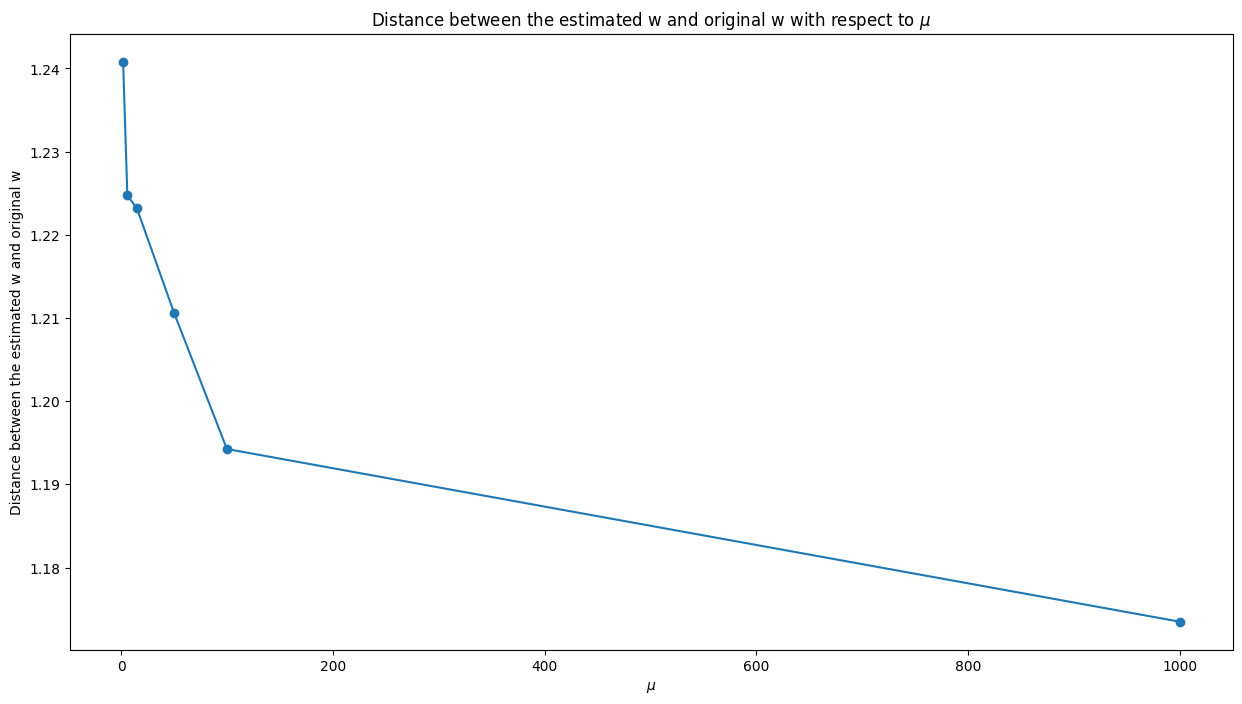

In [29]:
dist = []
for m in mus:
    v_list  = barr_method (Q, p, A, b, v0, eps)

    w_est = np.dot(np.linalg.pinv(X), y - v_list[-1])
    print(w_est.shape)
    w_est /= np.linalg.norm(w_est)
    w /= np.linalg.norm(w)

    dist.append(np.linalg.norm(w_est - w))

plt.figure(figsize=(15,8))
plt.plot(mus, dist, marker = 'o')
plt.ylabel("Distance between the estimated w and original w")
plt.xlabel('$\mu$')
plt.title('Distance between the estimated w and original w with respect to $\mu$')
plt.savefig("dist")
plt.show()
